# Feature Engineering for Stock Price Prediction

This notebook creates engineered features including:
- Technical indicators (SMA, EMA, RSI, MACD, Bollinger Bands)
- Lag features and rolling statistics
- Volatility features
- Target variable definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Data

In [2]:
# Load cleaned data from EDA
df = pd.read_csv('../stock_data.csv', parse_dates=['dt'])
df.set_index('dt', inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
df.head()

Dataset shape: (8597, 12)
Date range: 1990-01-03 00:00:00 to 2024-02-16 00:00:00


,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day
dt,,,,,,,,,,,,
1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002
1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010
1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013
1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012
1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009


## 2. Price-Based Features

In [3]:
# Daily returns
df['daily_return'] = df['sp500'].pct_change()

# Log returns
df['log_return'] = np.log(df['sp500'] / df['sp500'].shift(1))

# Price change
df['price_change'] = df['sp500'].diff()

# Percentage change over multiple periods
for period in [3, 5, 10, 20]:
    df[f'pct_change_{period}d'] = df['sp500'].pct_change(periods=period)
    df[f'price_change_{period}d'] = df['sp500'].diff(periods=period)

print("Price-based features created:")
print([col for col in df.columns if 'return' in col or 'change' in col])

Price-based features created:
['daily_return', 'log_return', 'price_change', 'pct_change_3d', 'price_change_3d', 'pct_change_5d', 'price_change_5d', 'pct_change_10d', 'price_change_10d', 'pct_change_20d', 'price_change_20d']


## 3. Technical Indicators

In [4]:
# Simple Moving Averages
for window in [5, 10, 20, 50, 200]:
    df[f'SMA_{window}'] = df['sp500'].rolling(window=window).mean()
    df[f'price_to_SMA_{window}'] = df['sp500'] / df[f'SMA_{window}']

# Exponential Moving Averages
for span in [12, 26]:
    df[f'EMA_{span}'] = df['sp500'].ewm(span=span, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

print("\nMoving averages and MACD created")


Moving averages and MACD created


In [5]:
# RSI (Relative Strength Index)
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['sp500'], period=14)

print("RSI calculated")

RSI calculated


In [6]:
# Bollinger Bands
window = 20
df['BB_middle'] = df['sp500'].rolling(window=window).mean()
df['BB_std'] = df['sp500'].rolling(window=window).std()
df['BB_upper'] = df['BB_middle'] + (2 * df['BB_std'])
df['BB_lower'] = df['BB_middle'] - (2 * df['BB_std'])
df['BB_width'] = df['BB_upper'] - df['BB_lower']
df['BB_position'] = (df['sp500'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

print("Bollinger Bands calculated")

Bollinger Bands calculated


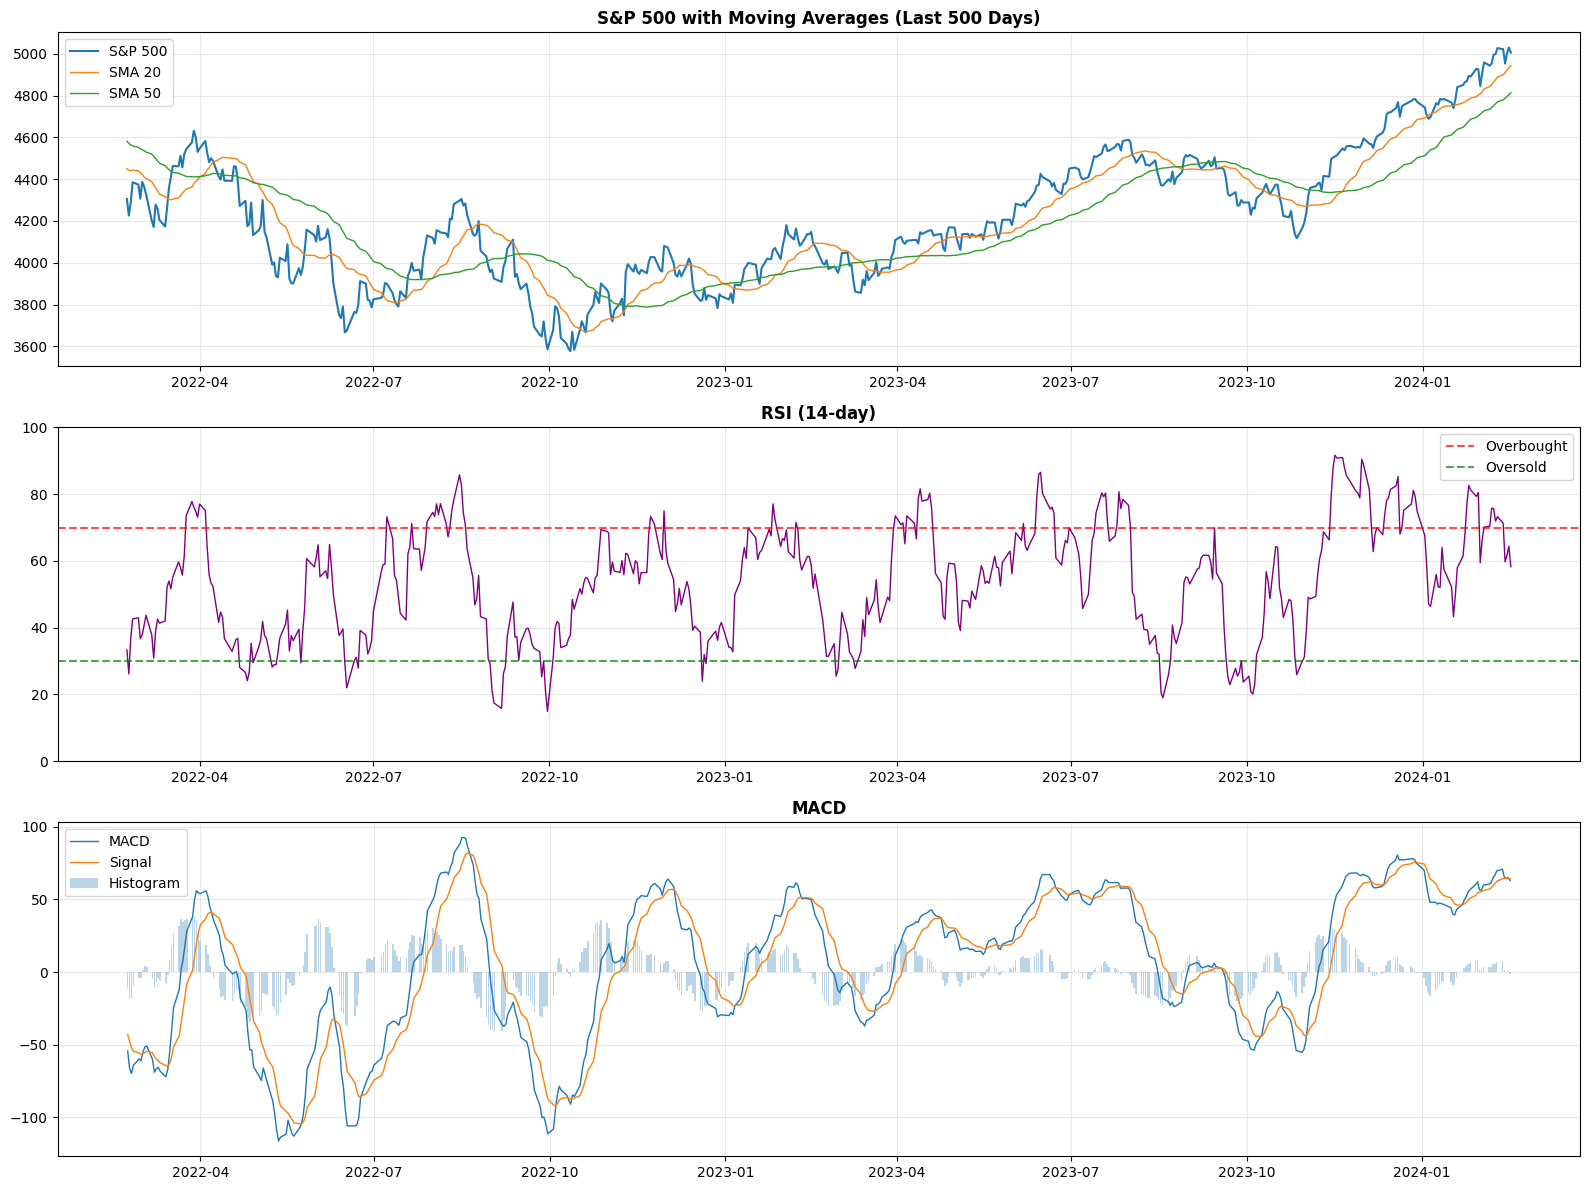

In [7]:
# Visualize technical indicators
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Price with moving averages
axes[0].plot(df.index[-500:], df['sp500'][-500:], label='S&P 500', linewidth=1.5)
axes[0].plot(df.index[-500:], df['SMA_20'][-500:], label='SMA 20', linewidth=1)
axes[0].plot(df.index[-500:], df['SMA_50'][-500:], label='SMA 50', linewidth=1)
axes[0].set_title('S&P 500 with Moving Averages (Last 500 Days)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RSI
axes[1].plot(df.index[-500:], df['RSI_14'][-500:], linewidth=1, color='purple')
axes[1].axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought')
axes[1].axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold')
axes[1].set_title('RSI (14-day)', fontweight='bold')
axes[1].set_ylim(0, 100)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MACD
axes[2].plot(df.index[-500:], df['MACD'][-500:], label='MACD', linewidth=1)
axes[2].plot(df.index[-500:], df['MACD_signal'][-500:], label='Signal', linewidth=1)
axes[2].bar(df.index[-500:], df['MACD_histogram'][-500:], label='Histogram', alpha=0.3)
axes[2].set_title('MACD', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Lag Features

In [8]:
# Lagged price features
for lag in [1, 2, 3, 5, 10]:
    df[f'sp500_lag_{lag}'] = df['sp500'].shift(lag)
    df[f'return_lag_{lag}'] = df['daily_return'].shift(lag)
    df[f'vix_lag_{lag}'] = df['vix'].shift(lag)

# Lagged volume
for lag in [1, 2, 5]:
    df[f'volume_lag_{lag}'] = df['sp500_volume'].shift(lag)

print(f"Lag features created: {len([col for col in df.columns if 'lag' in col])} features")

Lag features created: 18 features


## 5. Rolling Window Features

In [9]:
# Rolling statistics
for window in [5, 10, 20]:
    df[f'rolling_mean_{window}'] = df['sp500'].rolling(window=window).mean()
    df[f'rolling_std_{window}'] = df['sp500'].rolling(window=window).std()
    df[f'rolling_min_{window}'] = df['sp500'].rolling(window=window).min()
    df[f'rolling_max_{window}'] = df['sp500'].rolling(window=window).max()
    df[f'rolling_median_{window}'] = df['sp500'].rolling(window=window).median()
    
    # Position relative to rolling window
    df[f'position_in_range_{window}'] = (df['sp500'] - df[f'rolling_min_{window}']) / \
                                         (df[f'rolling_max_{window}'] - df[f'rolling_min_{window}'])

print(f"Rolling window features created")

Rolling window features created


## 6. Volatility Features

In [10]:
# Historical volatility (rolling std of returns)
for window in [5, 10, 20]:
    df[f'volatility_{window}'] = df['daily_return'].rolling(window=window).std() * np.sqrt(252)

# VIX changes
df['vix_change'] = df['vix'].diff()
df['vix_pct_change'] = df['vix'].pct_change()
df['vix_momentum'] = df['vix'].diff(5)

# Volatility ratio (short-term vs long-term)
df['volatility_ratio'] = df['volatility_5'] / df['volatility_20']

print("Volatility features created")

Volatility features created


## 7. Volume Features

In [11]:
# Volume ratios
df['volume_ma_20'] = df['sp500_volume'].rolling(window=20).mean()
df['volume_ratio'] = df['sp500_volume'] / df['volume_ma_20']
df['volume_momentum'] = df['sp500_volume'].diff(5)
df['volume_change'] = df['sp500_volume'].pct_change()

print("Volume features created")

Volume features created


## 8. Temporal Features

In [12]:
# Extract temporal features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week
df['is_month_end'] = df.index.is_month_end.astype(int)
df['is_quarter_end'] = df.index.is_quarter_end.astype(int)

print("Temporal features created")

Temporal features created


## 9. Target Variable Engineering

We'll create multiple target variables for different prediction tasks

In [13]:
# REGRESSION TARGETS

# Next day price
df['target_price_next_day'] = df['sp500'].shift(-1)

# 5-day ahead price
df['target_price_5day'] = df['sp500'].shift(-5)

# Next day return
df['target_return_next_day'] = df['daily_return'].shift(-1)

print("Regression targets created")

Regression targets created


In [14]:
# CLASSIFICATION TARGETS

# Binary direction (next day)
df['target_direction_next_day'] = (df['sp500'].shift(-1) > df['sp500']).astype(int)

# Binary direction (5-day)
df['target_direction_5day'] = (df['sp500'].shift(-5) > df['sp500']).astype(int)

# Multi-class direction (-1: down, 0: flat, 1: up)
threshold = 0.005  # 0.5% threshold for "flat"
next_return = df['daily_return'].shift(-1)
df['target_multiclass'] = 0
df.loc[next_return > threshold, 'target_multiclass'] = 1
df.loc[next_return < -threshold, 'target_multiclass'] = -1

print(f"\nDirection distribution:")
print(df['target_direction_next_day'].value_counts())
print(f"\nMulti-class distribution:")
print(df['target_multiclass'].value_counts())


Direction distribution:
target_direction_next_day
1    4599
0    3998
Name: count, dtype: int64

Multi-class distribution:
target_multiclass
 0    4196
 1    2382
-1    2019
Name: count, dtype: int64


In [15]:
# BUY/SELL/HOLD SIGNALS based on local extrema
def identify_signals(prices, order=5):
    """
    Identify buy/sell signals based on local minima/maxima
    order: how many points on each side to compare
    """
    signals = np.zeros(len(prices))
    
    # Find local minima (BUY signals)
    local_min = argrelextrema(prices.values, np.less_equal, order=order)[0]
    signals[local_min] = 1  # BUY
    
    # Find local maxima (SELL signals)
    local_max = argrelextrema(prices.values, np.greater_equal, order=order)[0]
    signals[local_max] = -1  # SELL
    
    return signals

df['target_signals'] = identify_signals(df['sp500'], order=10)

print(f"\nSignals distribution:")
print(f"BUY signals: {(df['target_signals'] == 1).sum()}")
print(f"SELL signals: {(df['target_signals'] == -1).sum()}")
print(f"HOLD: {(df['target_signals'] == 0).sum()}")


Signals distribution:
BUY signals: 258
SELL signals: 239
HOLD: 8100


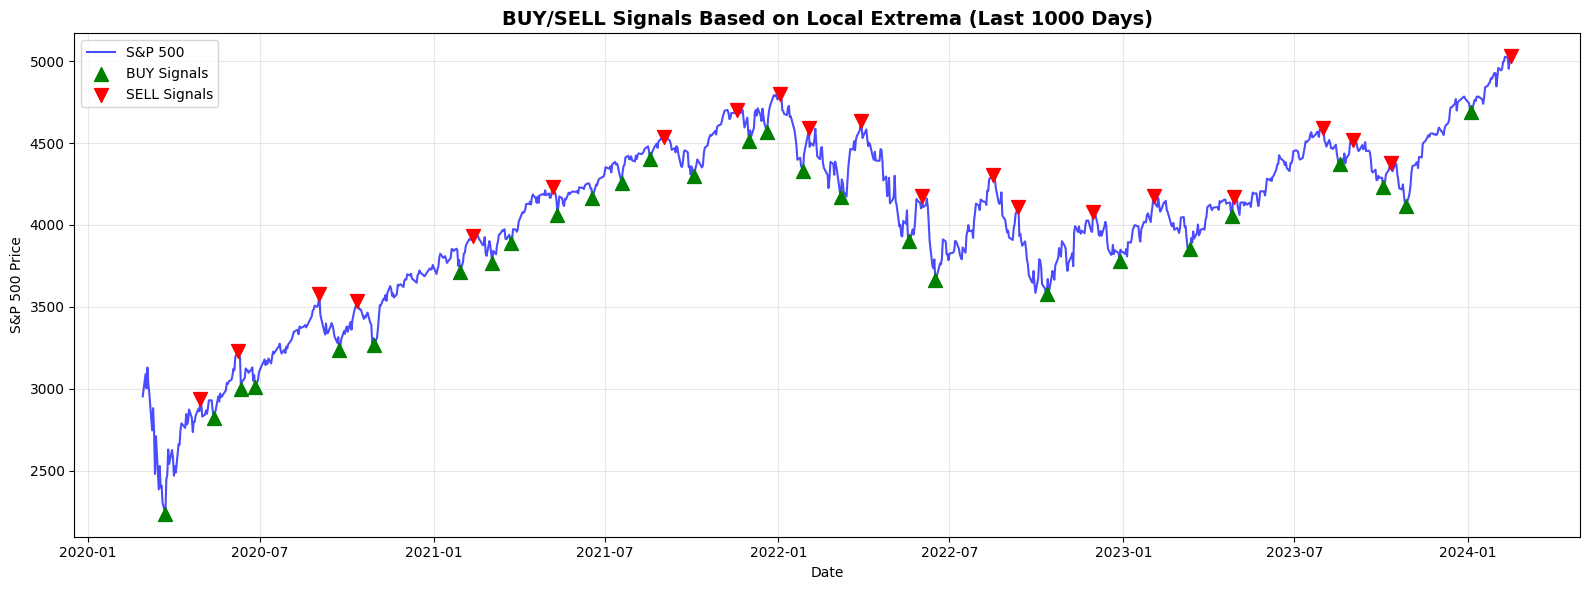

In [16]:
# Visualize signals
fig, ax = plt.subplots(figsize=(16, 6))

# Plot recent data
recent = df.tail(1000)
ax.plot(recent.index, recent['sp500'], label='S&P 500', linewidth=1.5, color='blue', alpha=0.7)

# Plot BUY signals
buy_signals = recent[recent['target_signals'] == 1]
ax.scatter(buy_signals.index, buy_signals['sp500'], color='green', marker='^', 
           s=100, label='BUY Signals', zorder=5)

# Plot SELL signals
sell_signals = recent[recent['target_signals'] == -1]
ax.scatter(sell_signals.index, sell_signals['sp500'], color='red', marker='v', 
           s=100, label='SELL Signals', zorder=5)

ax.set_title('BUY/SELL Signals Based on Local Extrema (Last 1000 Days)', fontweight='bold', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('S&P 500 Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Feature Summary and Data Quality

In [17]:
print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"\nTotal features created: {len(df.columns)}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total observations: {len(df):,}")

# Count features by category
categories = {
    'Price-based': ['return', 'change'],
    'Technical Indicators': ['SMA', 'EMA', 'MACD', 'RSI', 'BB'],
    'Lag Features': ['lag'],
    'Rolling Features': ['rolling'],
    'Volatility': ['volatility', 'vix'],
    'Volume': ['volume'],
    'Temporal': ['day', 'month', 'quarter', 'week'],
    'Target Variables': ['target']
}

for category, keywords in categories.items():
    count = sum(1 for col in df.columns if any(kw in col.lower() for kw in keywords))
    print(f"{category}: {count} features")

# Missing values after feature engineering
missing = df.isnull().sum()
print(f"\nFeatures with missing values: {(missing > 0).sum()}")
print(f"Max missing count: {missing.max()} ({missing.max()/len(df)*100:.2f}%)")

FEATURE ENGINEERING SUMMARY

Total features created: 106
Date range: 1990-01-03 00:00:00 to 2024-02-16 00:00:00
Total observations: 8,597
Price-based: 20 features
Technical Indicators: 0 features
Lag Features: 18 features
Rolling Features: 15 features
Volatility: 13 features
Volume: 9 features
Temporal: 13 features
Target Variables: 7 features

Features with missing values: 78
Max missing count: 199 (2.31%)


## 11. Handle Missing Values and Save

In [18]:
# Drop rows with missing values (mostly from rolling windows at start)
print(f"Rows before cleaning: {len(df):,}")
df_clean = df.dropna()
print(f"Rows after cleaning: {len(df_clean):,}")
print(f"Rows removed: {len(df) - len(df_clean):,}")

# Alternative: could use forward fill for specific features
# df_clean = df.fillna(method='ffill').dropna()

Rows before cleaning: 8,597
Rows after cleaning: 8,393
Rows removed: 204


In [19]:
# Save engineered features
output_path = '../data/processed/features_engineered.csv'
df_clean.to_csv(output_path)
print(f"\nEngineered features saved to: {output_path}")
print(f"Final dataset shape: {df_clean.shape}")
print(f"Features: {df_clean.shape[1]} columns")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")


Engineered features saved to: ../data/processed/features_engineered.csv
Final dataset shape: (8393, 106)
Features: 106 columns
Date range: 1990-10-16 00:00:00 to 2024-02-09 00:00:00


In [20]:
# Display sample of engineered features
feature_cols = [col for col in df_clean.columns if 'target' not in col]
print(f"\nSample of engineered features (first 5 rows, random 10 features):")
sample_features = np.random.choice(feature_cols, size=min(10, len(feature_cols)), replace=False)
df_clean[sample_features].head()


Sample of engineered features (first 5 rows, random 10 features):


,daily_return,sp500_lag_10,sp500_lag_2,rolling_mean_20,rolling_median_20,return_lag_10,vix_lag_2,SMA_5,rolling_min_20,vix_pct_change
dt,,,,,,,,,,
1990-10-16,-0.014214,315.209991,300.029999,307.334003,307.154999,0.000857,31.94,299.606006,295.459991,-0.006005
1990-10-17,-0.000535,311.399994,303.230011,306.442003,305.574997,-0.012087,31.64,299.280005,295.459991,-0.002544
1990-10-18,0.023363,312.690002,298.920013,306.155002,305.419998,0.004143,31.45,301.336005,295.459991,-0.056423
1990-10-19,0.022045,311.500000,298.760010,306.213002,305.419998,-0.003806,31.37,303.826007,295.459991,-0.058784
1990-10-22,0.007296,313.480011,305.739990,306.721503,305.894989,0.006356,29.60,306.132007,295.459991,-0.021177


## 12. Feature Correlation with Targets

In [21]:
# Calculate correlation with regression target
target_col = 'target_return_next_day'
correlations = df_clean.corr()[target_col].sort_values(ascending=False)

print(f"\nTop 20 features correlated with {target_col}:")
print(correlations.head(20))

print(f"\nBottom 20 features (negative correlation):")
print(correlations.tail(20))


Top 20 features correlated with target_return_next_day:
target_return_next_day       1.000000
target_multiclass            0.798271
target_direction_next_day    0.665708
target_direction_5day        0.282408
target_signals               0.211972
vix_change                   0.080247
vix_momentum                 0.052793
vix                          0.038421
vix_pct_change               0.035082
is_month_end                 0.028791
vix_lag_3                    0.024436
is_quarter_end               0.022112
vix_lag_1                    0.021930
vix_lag_2                    0.020979
vix_lag_10                   0.020829
vix_lag_5                    0.017907
GPRD                         0.015856
day_of_month                 0.015546
volatility_20                0.012308
quarter                      0.011923
Name: target_return_next_day, dtype: float64

Bottom 20 features (negative correlation):
position_in_range_20   -0.028333
RSI_14                 -0.028378
price_change_20d       -0.02

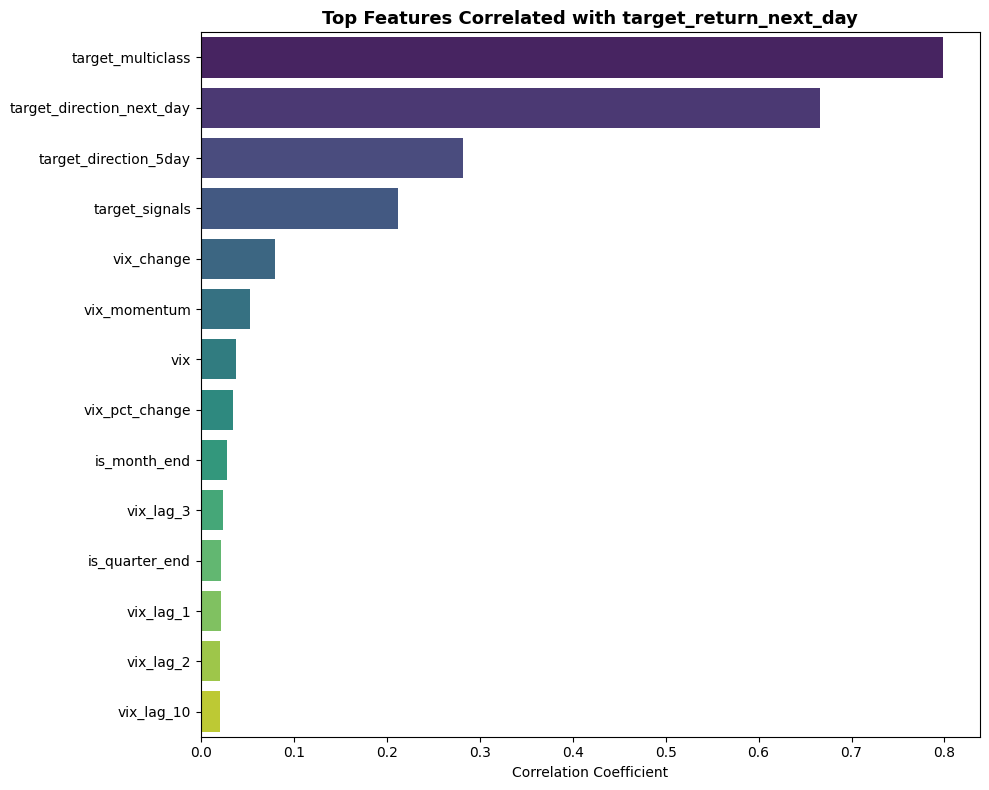

In [22]:
# Visualize top correlations
top_features = correlations.head(15).index.tolist()
top_features = [f for f in top_features if f != target_col]

plt.figure(figsize=(10, 8))
sns.barplot(x=correlations[top_features].values, y=top_features, palette='viridis')
plt.title(f'Top Features Correlated with {target_col}', fontweight='bold', fontsize=13)
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

## Next Steps

With engineered features ready, you can now:
1. Split data temporally (use `src/preprocessing.py`)
2. Train baseline models for benchmarking
3. Train XGBoost/LightGBM models
4. Train LSTM/GRU deep learning models
5. Evaluate and compare models
6. Backtest trading strategies